# PC setting

In [1]:
# !pip install -r requirements_uavUnet.txt
from google.colab import drive
drive.mount('/content/drive')

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_properties = torch.cuda.get_device_properties(device)
    gpu_memory_size = gpu_properties.total_memory / 1024 ** 3  # Convert bytes to gigabytes
    print(f"GPU Memory Size: {gpu_memory_size:.2f} GB")
else:
    print("GPU is not available.")


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd /content/drive/MyDrive/Forest/src/

# Import modules

In [2]:


import os, glob, sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import random
from PIL import Image

# print(f"GPU Memory Usage: {get_gpu_memory_usage():.2f} GiB\n")
# print("Allocated Tensors:")
# print_allocated_tensors()

import segment_model_training
import importlib
importlib.reload(segment_model_training)
import cv2
from matplotlib import pyplot as plt

from segment_model_training import calculate_statistics,LoadDataSet,get_train_transform
from fpathutils import copyLocaliImages, get_mskPath
# importlib.reload(argmentDataset)
# importlib.reload(get_train_transform)

GPU Memory Size: 16.00 GB
GPU Memory Size: 16.00 GB


# LoadDatasets

In [3]:

datasetName = "Forest tsumura 2 50m P4Pv2"
treeType = "cypress"
cropSize = 1024
lapSize=512

# orgDir = f"03_datasetforModel\\{datasetName}_{treeType}\\org_crop4Corner_5120_3072_Size{cropSize}_lap{lapSize}".replace("\\","/")
orgDir = f"C:\\datas\\uav_cnn_cypress\\test_org_crop4Corner_5120_3072_Size1024_lap512"
orgPaths = glob.glob(orgDir + "/*.*")

len(orgPaths)

# フォルダのパスを指定して統計量を計算
# mean_values, std_deviation = calculate_statistics(orgDir)
mean_values, std_deviation = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
print("正規化ずみ平均値:", mean_values)
print("正規化ずみ標準偏差:", std_deviation)


正規化ずみ平均値: (0.485, 0.456, 0.406)
正規化ずみ標準偏差: (0.229, 0.224, 0.225)


In [4]:

# calculate_statistics(orgPaths)

In [5]:

orgDataset_count = len(glob.glob(orgDir + "/*.*"))

rotate_270per90 = True
flipMirror = True

# orgDir = segment_model_training.argmentDataset(orgDir, rotate=rotate_270per90, flipMirror=True)
# segment_model_training.main("cedar",2)


workDir = "./04_trainingModel"
TRAIN_PATH = workDir + f'/{datasetName}_{treeType}/'
os.makedirs(TRAIN_PATH, exist_ok=True)
orgDataset_count

28

In [6]:

orgPaths = glob.glob(orgDir + "/*.*")
img = Image.open(orgPaths[0])
mskPaths = [get_mskPath(orgPath) for orgPath in orgPaths]
print(len(orgPaths),len(mskPaths))

# orgDir = copyLocaliImages(orgDir, f"C:\\datas\\uav_cnn_{treeType}")
# orgPaths = glob.glob(orgDir + "/*.*")


print(orgDir)

28 28
C:\datas\uav_cnn_cypress\test_org_crop4Corner_5120_3072_Size1024_lap512


# PSQL connect

In [7]:
# import psql_connect
# importlib.reload(psql_connect)

# engine, conn, engineSQL = psql_connect.getPSQL(databaseName="cnn_segment", port="5432", ownerName="matsuilocal")

# psql_connect.createTB_UnetDatasetUAV()
# psql_connect.createTB_UnetTrainingUAV()

In [8]:
# from sqlalchemy import create_engine, Table, Column, Integer, String, Float, MetaData
# from sqlalchemy.orm import sessionmaker

# # Define the metadata and the table
# metadata = MetaData()
# unet_dataset_uav = Table('unet_dataset_uav', metadata,
#                          Column('id', Integer, primary_key=True),
#                          Column('datasetName', String),
#                          Column('classType', String),
#                          Column('width', Integer),
#                          Column('height', Integer),
#                          Column('lapSize', Integer),
#                          Column('original_dataset_count', Integer),
#                          Column('argment_rotate', String),
#                          Column('argment_flipMirror', String),
#                          Column('datasetDir', String),
#                          Column('dataset_count', Integer),
#                          Column('mean', String),
#                          Column('std', String),
#                      )
# import ast

# select_SQL = "select * from unet_dataset_uav;"

# df_db = pd.read_sql(sql=select_SQL, con=engineSQL)
# if not str(list(mean_values)) in list(df_db["mean"]):
# # mean_values_fromDB = ast.literal_eval(df_db.loc[0,"mean"])
#     # Create a session
#     Session = sessionmaker(bind=engine)
#     session = Session()

#     # Create a new row to insert
#     new_row = unet_dataset_uav.insert().values(
#         datasetName=datasetName,
#         classType=treeType,
#         width=img.width,
#         height=img.height,
#         lapSize=lapSize,
#         original_dataset_count=orgDataset_count,
#         argment_rotate=rotate_270per90,
#         argment_flipMirror=flipMirror,
#         datasetDir=orgDir,
#         dataset_count=len(orgPaths),
#         mean=str(list(mean_values)),
#         std=str(list(std_deviation)),
#     )
#     print(new_row)

#     try:
#         # Execute the insert statement
#         session.execute(new_row)

#         # Commit the changes
#         session.commit()

#         # Close the session
#         session.close()
#     except Exception as e:
#         print(e)
#         session.close()

In [9]:
# datasetID = int(df_db["id"][0])


# getDatasetParam_SQL = f"select * from unet_dataset_uav where id={4};"
# df = pd.read_sql(getDatasetParam_SQL,engine)
# df

In [10]:
# orgDir = df["datasetDir"].iloc[0]
# orgDir

# Dataset define

In [11]:
import segment_model_training
importlib.reload(segment_model_training)

print(orgDir.replace("\\","\\\\"))
train_dataset = segment_model_training.LoadDataSet(orgDir)
# train_dataset = LoadDataSet(orgDir.replace("\\","\\\\")+"\\")
print("images count\t",train_dataset.__len__())

org, msk = train_dataset.__getitem__(6)


segment_model_training.printArrayStatics(org)
segment_model_training.printArrayStatics(msk)

GPU Memory Size: 16.00 GB
C:\\datas\\uav_cnn_cypress\\test_org_crop4Corner_5120_3072_Size1024_lap512
images count	 28
torch.Size([3, 1024, 1024]) tensor(1.) tensor(0.4022) tensor(0.)
tensor([0.0000, 0.0042, 0.0083, 0.0125, 0.0167, 0.0208])
torch.Size([1, 1024, 1024]) tensor(0.) tensor(0.) tensor(0.)
tensor([0.])


In [12]:
print(org.dtype, msk.dtype)

torch.float32 torch.float32


In [72]:

BATCHSIZE = 2

#データ前処理
split_ratio = 0.3
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))

print(f"train count : {(train_size)}")
print(f"valid count : {(valid_size)}")


train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=BATCHSIZE)


train count : 20
valid count : 8


# Models module Load

  0%|                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

Epoch 0 	Loss tensor([0.9489], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([1.3329e-13], device='cuda:0')
Epoch 0 	Loss tensor([0.9305], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([0.0400], device='cuda:0')
Epoch 0 	Loss tensor([0.7477], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([0.2614], device='cuda:0')
Epoch 0 	Loss tensor([0.8169], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([0.1976], device='cuda:0')
Epoch 0 	Loss tensor([0.9158], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([0.0653], device='cuda:0')
Epoch 0 	Loss tensor([0.9486], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([1.3176e-13], device='cuda:0')
Epoch 0 	Loss tensor([0.4998], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([0.3601], device='cuda:0')
Epoch 0 	Loss tensor([0.8111], device='cuda:0', grad_fn=<Unique2Backward0>) 	IoU tensor([0.2078], device='cuda:0')
Epoch 0 	Loss tensor([0.8305], device='cuda:0', grad_fn=<Unique2Backward

  0%|                                                                                                                                                                       | 0/5 [00:04<?, ?it/s]


OSError: [Errno 22] Invalid argument: './04_trainingModel\\class-cypress_data28_batch2_epoch100_modelresnet34-imagenet\\traingSet_Epoch1_class-cypress_data28_batch2_epoch5_modelvgg16-imagenet.png'

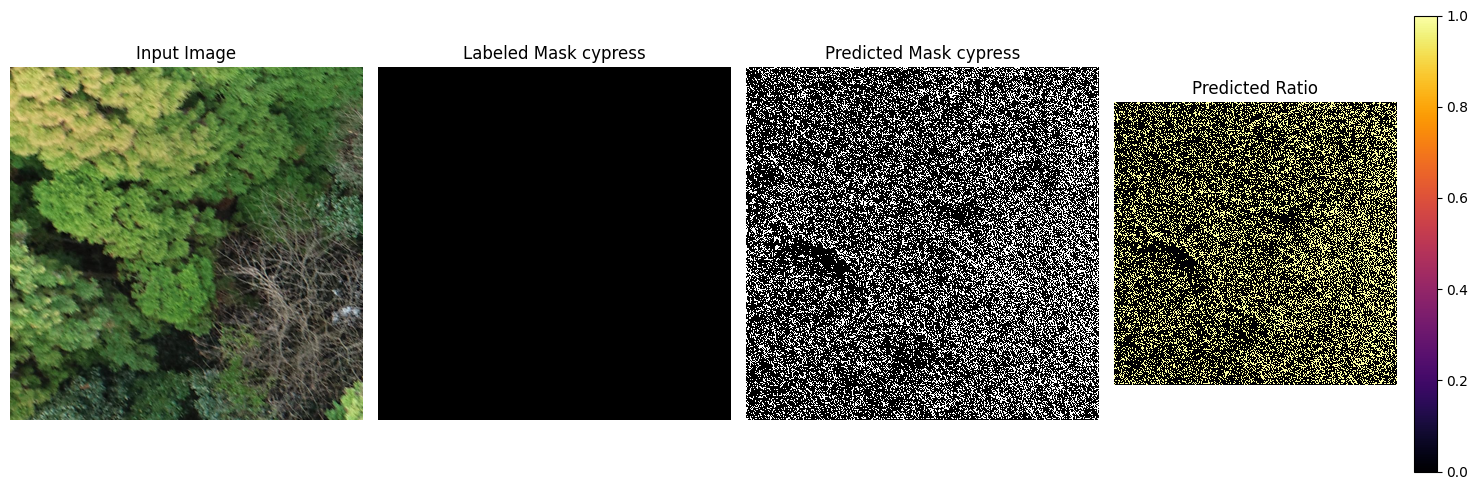

In [93]:
# !pip install segmentation_models_pytorch
from torch import nn
from unet_model import UNet, DiceBCELoss, save_ckp, load_ckp
from pre_segmentation_model import UnetModel, calculate_iou, validateModel
import segmentation_models_pytorch as smp

import pre_segmentation_model
importlib.reload(pre_segmentation_model)

encoder_name = "vgg16"
encoder_weight = "imagenet"
DEVICE = "cuda"
num_epochs = 5

model = pre_segmentation_model.UnetModel(encoder_name, encoder_weight, in_ch=3, outClass=1, activationName="sigmoid")
modelID = "class-{}_data{}_batch{}_epoch{}_model{}".format(treeType,train_dataset.__len__(), BATCHSIZE, num_epochs, encoder_name + "-" + encoder_weight)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# optimizer = torch.optim.Adam([dict(model.parameters(),lr = 1e-3))])
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=1e-9)])
# 損失関数を定義します。セグメンテーションタスクのためにCrossEntropyLossを使用します。
# criterion = nn.CrossEntropyLoss()


# criterion = smp.utils.losses.DiceLoss()
criterion = smp.utils.losses.BCEWithLogitsLoss()

accuracy_metric = smp.utils.metrics.IoU(threshold=0.5)
metrics = [accuracy_metric]
# valid_loss_min = np.Inf


torch.cuda.empty_cache()
# CuDNNを使用したネットワークのベンチマークを有効にし、パフォーマンスを最適化します。
torch.backends.cudnn.benchmark = True

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE
)


# データローダー（train_loader, val_loaderなど）を定義した後、訓練ループを開始します。
for epoch in tqdm(range(num_epochs)):
    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # 前方計算を行います。
        predicts = model(images)
        
        # print(predicts.shape, masks.shape)
        # print("\tPred,mask",predicts.cpu().min(), predicts.cpu().max(), masks.cpu().min(), masks.cpu().max())
        # predicts[predicts>=0.5] = 1.0

        # 損失を計算します。
        loss = criterion(predicts, masks)
        batch_iou = metrics[0](predicts, masks)
        print("Epoch",epoch,"\tLoss", loss.unique(),"\tIoU",batch_iou.unique())
        
        
        
        
        # 勾配を初期化します。
        optimizer.zero_grad()

        # バックプロパゲーションを行います。
        loss.backward()

        # オプティマイザを更新します。
        optimizer.step()

    # バリデーションデータでモデルのパフォーマンスを評価します。
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # 前方計算を行います。
            predicts = model(images)
            
            print(predicts.unique())
            pred_show = predicts[0]
            pred_show = (pred_show >= 0.5).float()
            print(pred_show.unique())
            
            segment_model_training.savePred(img_show=images[0],
                                            msk_show=masks[0],
                                            pred=pred_show,
                                            # mean_values=mean_values,
                                            # std_deviation=std_deviation,
                                            mean_values=[0,0,0],
                                            std_deviation=[0,0,0],
                                            workDir=workDir,
                                            epoch=epoch,
                                            modelID=modelID)
            
            # ここで必要なら評価指標を計算します。

# モデルを保存します。
torch.save(model.state_dict(), 'model.pth')

In [ ]:
checkpoint_path = os.path.join(workDir,f'model_{treeType}_chkpoint_')
best_model_path = os.path.join(workDir,f'model_{treeType}_bestmodel.pt')
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

print(checkpoint_path)
print(best_model_path)

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []
losses_value = 0


def get_gpu_memory_usage():
    """GPUメモリの使用量を取得する関数"""
    return torch.cuda.memory_allocated() / 1024**3  # GiB単位で返す

def print_allocated_tensors():
    """GPUメモリを占有している変数の一覧を表示する関数"""
    tensor_list = torch.cuda.memory_summary()  # 現在GPUメモリに割り当てられているテンソルの一覧を取得
    print(tensor_list)

# 使用例
print(f"GPU Memory Usage: {get_gpu_memory_usage():.2f} GiB\n")
# print_allocated_tensors()

In [35]:
patience = 5 # 5Epcoch以上連続でモデル精度が向上しなければEarly Stopping
early_stop_counter = 0

from pprint import pprint

max_score = 0
for i in range(num_epochs):
    
    print(f"Epoch:{i+1}")
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    pprint(train_logs)
    pprint(valid_logs)
    
#     # IoUスコアが最高値が更新されればモデルを保存
#     if max_score < valid_logs["iou_score"]:
#         max_score = valid_logs["iou_score"]
#         torch.save(model, checkpoint_path)
#         print("Model saved!")
#         early_stop_counter = 0

#     else:
#         early_stop_counter += 1
#         print(f"not improve for {early_stop_counter}Epoch")
#         if early_stop_counter==patience:
#             print(f"early stop. Max Score {max_score}")
#             break

    # 適当なタイミングでlearning rateの変更
    if i == 10:
        optimizer.param_groups[0]["lr"] = 1e-5
        print("Decrease decoder learning rate to 1e-5")

Epoch:1
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s, dice_loss - 0.7046, iou_score - 0.214]
{'dice_loss': 0.6238444685935974, 'iou_score': 0.29052696228027824}
{'dice_loss': 0.7046153396368027, 'iou_score': 0.21398758888247016}
Epoch:2
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s, dice_loss - 0.7046, iou_score - 0.214]
{'dice_loss': 0.5935942053794862, 'iou_score': 0.29052696228028296}
{'dice_loss': 0.7046153396368027, 'iou_score': 0.21398758888247016}
Epoch:3
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s, dice_loss - 0.7046, iou_score - 0.214]
{'dice_loss': 0.6111746370792389, 'iou_score': 0.2905269622802782}
{'dice_loss': 0.7046153396368027, 'iou_score': 0.213

In [36]:
workDir = "./04_trainingModel"

from segment_model_training import showPred
importlib.reload(segment_model_training)



workDir = os.path.join(workDir, modelID) + "\\"
os.makedirs(workDir, exist_ok=True)

img_show, msk_show = random.choice(valid_data)
# img_show[img_show<=0]=0
print("0 org_test.unique()",np.unique(img_show)[:50]) 
print("0 msk_show.unique()",np.unique(msk_show)) 


img_pred = torch.stack([org, org])
# pred = model(img_show.cuda())
pred = torch.sigmoid(model(img_pred.cuda()))
print("0 pred_sig.unique()",np.unique(pred.data.cpu())) 
pred = pred[0][0]
print("predShape",pred.shape,pred.data.cpu().dtype)
print(msk_show.dtype)
print("0 pred.unique()",np.unique(pred.data.cpu())) 
img_show = img_show.cuda()

print(workDir)
print(modelID)
segment_model_training.showPred(img_show=img_show, msk_show=msk_show, pred=pred,
         mean_values=mean_values, std_deviation=std_deviation,
         workDir=workDir, epoch=1, modelID="testmodel",
         imgSave=True)    
print(org.shape)


# pred = model(org)[0][0]
# pred.shape

GPU Memory Size: 16.00 GB
0 org_test.unique() [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687]
0 msk_show.unique() [1.]
0 pred_sig.unique() [0.73105854]
predShape torch.Size([1024, 1024]) torch.float32
torch.float32
0 pred.unique() [0.73105854]
./04_trainingModel\class-cypress_data28_batch2_epoch100_modelresnet34-imagenet\
class-cypress_data28_batch2_epoch100_modelresnet34-imagenet
img_show.shape (1024, 1024, 3)
msk_show.shape (1024, 1024)
output.shape torch.Size([1024, 1024])
pred.sh

In [ ]:
data = {'dataset_Mean': mean_values, 'dataset_Std Deviation': std_deviation}
df_statics = pd.DataFrame(data)
# DataFrameをCSVファイルとして保存
df_statics.to_csv(workDir + f"statistics_{modelID}.csv", index=False)


In [ ]:
# del pre_segmentation_model
import pre_segmentation_model
importlib.reload(pre_segmentation_model)

<module 'pre_segmentation_model' from 'H:\\マイドライブ\\Forest\\src\\pre_segmentation_model.py'>

In [38]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {str(epoch+1)}/{str(num_epochs)}")

#<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    train_loader_pbar = tqdm(train_loader, desc = 'description')
    valid_loss_min = 0
    
    #<---------------評価---------------------->
    losses_value, score = pre_segmentation_model.validateModel(model, train_loader_pbar, workDir=workDir,epoch=epoch,means=mean_values,stds=std_deviation, modelID=modelID)

    train_loss.append(losses_value)
    train_score.append(score)
    
    train_loader_pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    
    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    print("CheckPoint Save",modelID)

    # checkpointの保存
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]
    
    print("")


    score = {
        # "epoch" : range(1,num_epochs+1),
        "train_Loss" : total_train_loss,
        "valid__Loss" : total_valid_loss,
        "train_scoreIoU" : total_train_score,
        "valid__scoreIoU" : total_valid_score,
        }

    import pandas as pd
    df_score = pd.DataFrame(score, index=range(1,len(total_train_loss)+1))
    df_score.to_csv(workDir + f"scoreSheet_{modelID}.csv")




Epoch 1/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.90it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533696651459, Train IOU: 0.2905269622802782
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 2/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.96it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.911653357744217, Train IOU: 0.2905269622802782
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 3/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.911653357744217, Train IOU: 0.2905269622802782
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 4/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533935070038, Train IOU: 0.2905269622802782
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 5/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.75it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533637046814, Train IOU: 0.29052696228028774
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 6/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.82it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533458232879, Train IOU: 0.29052696228028296
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 7/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533786058426, Train IOU: 0.29052696228028296
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 8/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533517837524, Train IOU: 0.29052696228028296
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 9/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533696651459, Train IOU: 0.29052696228028296
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 10/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.95it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.911653357744217, Train IOU: 0.29052696228028296
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 11/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533815860748, Train IOU: 0.2905269622802782
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 12/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.86it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533696651459, Train IOU: 0.2905269622802782
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 13/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533815860748, Train IOU: 0.29052696228027824
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 14/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.91it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533726453782, Train IOU: 0.29052696228027824
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 15/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533875465394, Train IOU: 0.29052696228028296
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 16/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533637046814, Train IOU: 0.2905269622802782
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 17/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533517837524, Train IOU: 0.29052696228027824
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 18/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.81it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.91165332198143, Train IOU: 0.2905269622802877
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 19/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.90it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.911653333902359, Train IOU: 0.29052696228028296
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

Epoch 20/20


description: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.89it/s]


Average Loss: 0.9117
Average IoU: 0.2905
Train Loss: 0.9116533517837524, Train IOU: 0.2905269622802877
Valid Loss: nan, Valid IOU: nan
CheckPoint Save class-cypress_data28_batch2_epoch100_modelresnet34-imagenet

